# **Text Vectorization I**

---
### Natural Language Processing
Date: Nov 11, 2022

---

Our goal here is to provide a basic overview of the following aspects:


*   NLP preprocessing
*   Document BoW and TF-IDF representation
*   Utilization of the latter to solve a Text Classification task




In [ ]:
# Common imports
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

# Figures plotted inside the notebook
%matplotlib inline
# High quality figures
%config InlineBackend.figure_format = 'retina'
# Figures style
plt.style.use('seaborn-whitegrid')
sns.set_style("darkgrid")
sns.color_palette("deep")
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

<ipython-input-1-5aa9cf6e1fc1>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# For fancy table Display
%load_ext google.colab.data_table

We are going to save all the files in this notebook generated into our Drive. For doing so, you must fill the variable ``path_to_folder`` with your Drive's folder in which you want to save the files. Please, note that the home path to your Drive is given by:

``
/content/drive/My Drive/
``

Hence, if you want to save this lab's results into a folder named ``NLP_IA``, then the variable ``path_to_folder`` for you should look as follows:

``
path_to_folder = '/content/drive/My Drive/NLP_IA'
``

In [ ]:
path_to_folder = '/content/drive/MyDrive/NLP_IA'  # UPDATE THIS ACCORDING TO WHERE YOU WANT TO SAVE THE FILES!!!!

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory
os.chdir(path_to_folder)

Mounted at /content/drive


## **1. Data preparation**
---


### *1.1. Data loading*

The first step to start working with text vectorization is downloading the dataset with which we will work. Here we will be using the **IMDB Dataset of 50K Movie Reviews**, which contains 50K movie reviews for natural language processing or Text analytics.


In [ ]:
try:
  import opendatasets as od
except ModuleNotFoundError:
  %pip install opendatasets
  import opendatasets as od

The IMDB dataset can be downloaded from **Kaggle**. For doing so, you must create an account at [kaggle.com](https://www.kaggle.com/).

Once you have your account, go to ``Your profile`` and select ``Edit Public Profile``. If you scroll down in this view, you will see a button named ``Create New API Token``. By clicking it will automatically download a file ``kaggle.json`` containing your **username** and **key**. You will need them for executing the next cell.

You just need to execute the following cell once, since it will store the dataset file in the drive folder you have specified above.

In [ ]:
# TODO: Comment this cell after executing it the first time
od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


Let's save the dataset as dataframe.

This dataset is oriented toward binary sentence classification, i.e., the prediction of whether each of the reviews in the dataset is positive or negative using either classification or deep learning algorithms.

Hence, we have two columns in our dataframe: the ``review`` column contains the textual information and the ``sentiment`` column contains the output labels. Here we will be working first on the ``review`` column for applying distinct types of text vectorization, and finally, we will utilize the ``sentiment`` column to carry out the sentiment analysis task.

To accelerate the process, we will be only using a third of the reviews contained in the dataset.

In [ ]:
corpus_df = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
corpus_df = corpus_df.sample(frac=0.3, replace=True, random_state=1)
print(len(corpus_df))
corpus_df.head()

15000


,review,sentiment
33003,"Set in Paris in the year 1910, a retired old r...",positive
12172,"Basic structure of a story: Beginning, Middle,...",negative
5192,"An odd, willfully skewed biopic of Dyan Thomas...",negative
32511,"Okay, you have:<br /><br />Penelope Keith as M...",negative
43723,The larger-than-life figures of Wyatt Earp and...,positive


### *1.2. Preprocessing*

Before continuing with the vectorization task, we should structure and clean the text so that we only keep the information that allows us to capture the semantic content of the corpus. This will improve the result of our embeddings.

For this purpose, we will apply the following three steps, which are typical of any NLP processing task:

1.   Text Wrangling
2.   Tokenization
3.   Homogenization
4.   Cleaning

For the next steps, we will be using some methods available from:

*   [Natural Language Toolkit](https://www.nltk.org/)
*   [Beautiful Soup](https://pypi.org/project/beautifulsoup4/)
*   [Contractions](https://pypi.org/project/contractions/)
*   [re — Regular expression operations](https://docs.python.org/3/library/re.html)

In [ ]:
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 17.6 MB/s eta 0:00:00


#### *1.2.1. Text Wrangling*

If we inspect the reviews, we can see that they contain many HTML tags and some URLs that we do not want to keep for our text vectorization task since they don't add much value for understanding and analyzing the text.

Additionally, there are many English contractions ('ll, 're) that we would like to transform into their base form (will, are) to later help with the standardization process.

##### **Exercise 1**

Complete the function ``wrangle_text`` that performs the text wrangling task. For doing so:

*   Make use of the library ``BeautifulSoup`` with the parser ``"lxml"`` to get rid of all HTML tags.
*   Use the function ``re.sub`` to remove all URLs in text. To this function, we need to provide a **regular expression**, i.e., a special sequence of characters that help us match or find other strings or sets of strings, using a specialized syntax held in a pattern, and a string to replace the occurrences of the regular expression found. Typically, we would use define the regular expressions as raw strings in the form r'expression'.
You can identify URLs using the pattern ``r'https://\S+|www\.\S+'``.
* Use the method ``fix`` from the ``contractions`` library to expand the contractions.

Apply the ``wrangle_text`` function into the first positive ``review`` in the corpus and save the result into a variable named ``wrangled_review``. Print the review before and after making the text wrangling.


In [ ]:
#<SOL>
def wrangle_text(text):
  # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "lxml").get_text()
    text = re.sub(r'https://\S+|www\.\S+', '', text, count=0, flags=0)
    text = contractions.fix(text)
    return text
  # TODO: Implement
#</SOL>

print(colored('\n============= First review in corpus =============', 'blue'))

#<SOL>
print(corpus_df.iloc[0,0])
#</SOL>

print(colored('\n============= After wrangling result =============', 'blue'))

#<SOL>
print(wrangle_text(corpus_df.iloc[0,0]))
#</SOL>


============= First review in corpus =============
Set in Paris in the year 1910, a retired old rich opera singer decides to give her fortune away to her beautiful cat Duchess ( voiced by Eva Gabor) and her kittens, but the jealous butler Edgar comes up with a plan as he kidnaps the cats and leaves them in the countryside. Luckily for them with the help of a streetwise and independent tomcat named Thomas O'Malley ( voiced by Phil Harris) helps them get home especially meeting some of his good friends like the swinging' Scat Cat ( voiced by Scatman Crothers) and try to foil Edgar's plans.<br /><br />Very entertaining and edgy post-Walt Disney's death animated movie with a couple of nice jazzy tunes like the memorable "Everybody wants to be a cat", good voice acting and some terrific animation for it's time even in these times of computer animation. Not one of the greatest Disney animated movies but a cult Disney animated fave and one of the few gems of it's day that works well, highly 

#### *1.2.2. Tokenization*

Tokenization is the process of segmenting a text into words,
referred to as **tokens**. This procedure will often also break off punctuation symbols (commas, periods, etc.), phrases, and other possible meaningful elements from the text, such as separate tokens. The list of tokens resulting from tokenization becomes the input for the homogenization stage.

The [NLTK Tokenizer Package](https://www.nltk.org/api/nltk.tokenize.html) offers several functions to perform tokenization operations on any text string. Here we will be using the ``wordpunct_tokenize`` function, which allows the separation of punctuation marks. Since sometimes we will be interested in performing the tokenization at the sentence level, we can combine ``wordpunct_tokenize`` and ``sent_tokenize``.

##### **Exercise 2**

* Tokenize the ``wrangled_review`` at the word level using the ``wordpunct_tokenize`` function. Save the tokenized review in a variable named ``review_tokens``.
* Tokenize the the ``wrangled_review`` at the sentence level using the combination of ``wordpunct_tokenize`` and  ``sent_tokenize`` functions. Save the tokenized review in a variable named ``review_tokens_sent``.

In [ ]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

wrangled_review = wrangle_text(corpus_df.iloc[0,0])

print(colored('\n============= First review in corpus =============', 'blue'))
print(wrangled_review)

#<SOL>

# Using wordpunct_tokenize
review_tokens = wordpunct_tokenize(wrangled_review)

# Using wordpunct_tokenize and sent_tokenize
review_tokens_sent = []
separated_prhases = sent_tokenize(wrangled_review)
for i in separated_prhases:
  review_tokens_sent.append(wordpunct_tokenize(i))

#</SOL>

print(colored('\n============= First review (tokens) =============', 'blue'))
print(review_tokens)

print(colored('\n============= First review (tokens sent level) =============', 'blue'))
print(review_tokens_sent)


============= First review in corpus =============
Set in Paris in the year 1910, a retired old rich opera singer decides to give her fortune away to her beautiful cat Duchess ( voiced by Eva Gabor) and her kittens, but the jealous butler Edgar comes up with a plan as he kidnaps the cats and leaves them in the countryside. Luckily for them with the help of a streetwise and independent tomcat named Thomas O'Malley ( voiced by Phil Harris) helps them get home especially meeting some of his good friends like the swinging' Scat Cat ( voiced by Scatman Crothers) and try to foil Edgar's plans.Very entertaining and edgy post-Walt Disney's death animated movie with a couple of nice jazzy tunes like the memorable "Everybody wants to be a cat", good voice acting and some terrific animation for it is time even in these times of computer animation. Not one of the greatest Disney animated movies but a cult Disney animated fave and one of the few gems of it is day that works well, highly recommende

#### *1.2.3. Homogenization*

Homogenization is the process that aims to collapse all semantically equivalent words into a unique representative one. The homogenization process comes from multiple words sharing the same lexeme. For example, ``develop``, ``development``, ``developing``, ``developed``, ``developer``, ``developmental``, and ``developmentally``, are set of words that share the same lexeme or root and, therefore, have a certain relationship of meaning.

To homogenize the set of tokens obtained in the previous stage, the following steps need to be performed:


1.   **Lower-cased of the tokens**
2.   **Elimination of non-alphanumeric characters**, like periods, question marks, and exclamation points.
4.   **Word normalization (Stemming/Lemmatization)**, i.e., removing word terminations to preserve the root of the words and ignore grammatical information.

Let's see how to apply each of these steps to the previously selected review.

##### **Exercise 3**

Perform the following two transformations to ``review_tokens``:

1.   Convert the tokens to lowercase. Use the ``.lower()`` method.
2.   Remove non-alphanumeric tokens. You can detect them using the ``.isalnum()`` method.

Save the result in a variable named ``review_tokens_filtered``.

In [ ]:
# Lowering caps and filtering only alphanumeric words
review_tokens_lowered  = [palabra.lower() for palabra in review_tokens]
review_tokens_filtered = [palabra for palabra in review_tokens_lowered if palabra.isalnum()]
print(review_tokens)

print(review_tokens_filtered[0:30])

['Set', 'in', 'Paris', 'in', 'the', 'year', '1910', ',', 'a', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'to', 'give', 'her', 'fortune', 'away', 'to', 'her', 'beautiful', 'cat', 'Duchess', '(', 'voiced', 'by', 'Eva', 'Gabor', ')', 'and', 'her', 'kittens', ',', 'but', 'the', 'jealous', 'butler', 'Edgar', 'comes', 'up', 'with', 'a', 'plan', 'as', 'he', 'kidnaps', 'the', 'cats', 'and', 'leaves', 'them', 'in', 'the', 'countryside', '.', 'Luckily', 'for', 'them', 'with', 'the', 'help', 'of', 'a', 'streetwise', 'and', 'independent', 'tomcat', 'named', 'Thomas', 'O', "'", 'Malley', '(', 'voiced', 'by', 'Phil', 'Harris', ')', 'helps', 'them', 'get', 'home', 'especially', 'meeting', 'some', 'of', 'his', 'good', 'friends', 'like', 'the', 'swinging', "'", 'Scat', 'Cat', '(', 'voiced', 'by', 'Scatman', 'Crothers', ')', 'and', 'try', 'to', 'foil', 'Edgar', "'", 's', 'plans', '.', 'Very', 'entertaining', 'and', 'edgy', 'post', '-', 'Walt', 'Disney', "'", 's', 'death', 'animated', 'movie

At this point, we can choose between applying simple stemming or using lemmatization. We will try both to test their differences.

In [ ]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

stemmed_review = [stemmer.stem(el) for el in review_tokens_filtered]
print(colored('\n============= Stemmed review  =============', 'blue'))
print(stemmed_review)

lemmatized_review = [wnl.lemmatize(el) for el in review_tokens_filtered]
print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_review)


============= Stemmed review  =============
['set', 'in', 'pari', 'in', 'the', 'year', '1910', 'a', 'retir', 'old', 'rich', 'opera', 'singer', 'decid', 'to', 'give', 'her', 'fortun', 'away', 'to', 'her', 'beauti', 'cat', 'duchess', 'voic', 'by', 'eva', 'gabor', 'and', 'her', 'kitten', 'but', 'the', 'jealous', 'butler', 'edgar', 'come', 'up', 'with', 'a', 'plan', 'as', 'he', 'kidnap', 'the', 'cat', 'and', 'leav', 'them', 'in', 'the', 'countrysid', 'luckili', 'for', 'them', 'with', 'the', 'help', 'of', 'a', 'streetwis', 'and', 'independ', 'tomcat', 'name', 'thoma', 'o', 'malley', 'voic', 'by', 'phil', 'harri', 'help', 'them', 'get', 'home', 'especi', 'meet', 'some', 'of', 'his', 'good', 'friend', 'like', 'the', 'swing', 'scat', 'cat', 'voic', 'by', 'scatman', 'crother', 'and', 'tri', 'to', 'foil', 'edgar', 's', 'plan', 'veri', 'entertain', 'and', 'edgi', 'post', 'walt', 'disney', 's', 'death', 'anim', 'movi', 'with', 'a', 'coupl', 'of', 'nice', 'jazzi', 'tune', 'like', 'the', 'memor', '

One of the advantages of the lemmatizer method is that the result of lemmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization. Yet, it does not remove grammatical differences (e.g., is" or "our" are preserved and not replaced by the infinitive "be")

In the following, we will use lemmatization.

#### *1.2.4. Cleaning*

The third step consists of removing those words that are very common in language and do not carry out useful semantic content (articles, pronouns, etc.). For it, we will use the list of stopwords provided by NLTK.

##### **Exercise 4**

Clean ``lemmatized_review`` by removing all tokens in the stopwords list ``stopwords_en``. Save the result in a variable named ``clean_review``.


In [ ]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

#<SOL>
clean_review = [word for word in lemmatized_review if word not in stopwords_en]
#</SOL>

print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_review)
print(colored('\n============= Clean lemmatized review  =============', 'blue'))
print(clean_review)


============= Lemmatized review  =============
['set', 'in', 'paris', 'in', 'the', 'year', '1910', 'a', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'to', 'give', 'her', 'fortune', 'away', 'to', 'her', 'beautiful', 'cat', 'duchess', 'voiced', 'by', 'eva', 'gabor', 'and', 'her', 'kitten', 'but', 'the', 'jealous', 'butler', 'edgar', 'come', 'up', 'with', 'a', 'plan', 'a', 'he', 'kidnaps', 'the', 'cat', 'and', 'leaf', 'them', 'in', 'the', 'countryside', 'luckily', 'for', 'them', 'with', 'the', 'help', 'of', 'a', 'streetwise', 'and', 'independent', 'tomcat', 'named', 'thomas', 'o', 'malley', 'voiced', 'by', 'phil', 'harris', 'help', 'them', 'get', 'home', 'especially', 'meeting', 'some', 'of', 'his', 'good', 'friend', 'like', 'the', 'swinging', 'scat', 'cat', 'voiced', 'by', 'scatman', 'crothers', 'and', 'try', 'to', 'foil', 'edgar', 's', 'plan', 'very', 'entertaining', 'and', 'edgy', 'post', 'walt', 'disney', 's', 'death', 'animated', 'movie', 'with', 'a', 'couple', 'of', 'nic

##### **Exercise 5**

Complete the function ``prepare_data`` that performs all steps seen above (i.e., from text wrangling to cleaning).

Use the ``apply`` function to perform the transformation into all the ``review`` columns of the ``corpus_df`` dataframe and save the result in a new column named ``clean_review``.

In [ ]:
def prepare_data(text):
  wrangled_review = wrangle_text(text)
  review_tokens = wordpunct_tokenize(wrangled_review)
  review_tokens_lowered  = [palabra.lower() for palabra in review_tokens]
  review_tokens_filtered = [palabra for palabra in review_tokens_lowered if palabra.isalnum()]
  clean_review = [word for word in review_tokens_filtered if word not in stopwords_en]
  lemmatized_review = [wnl.lemmatize(el) for el in clean_review]
  return clean_review

corpus_df['clean_review'] = corpus_df['review'].apply(prepare_data)

<ipython-input-10-d29c62fa2240>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()


## **2. Basic Vectorization techniques**
---



In the following, we are going to be working with Gensim.

Gensim is a Python library intended for NLP practitioners. It provides a variety of methods for working with documents in textual format and carrying out semantic analysis tasks such as topic modeling or semantic comparison between documents. For this reason, Gensim is also widely used in Information Retrieval (IR) tasks.

Gensim is Open Source and is entirely programmed in Python, so it is easy to modify the code if necessary. The source code is hosted on the [Github development repository](https://github.com/RaRe-Technologies/gensim
).

Despite being fully developed in Python, Gensim makes extensive use of the Numpy and Scipy libraries that provide highly efficient implementations of certain matrix transformations and mathematical calculations, so Gensim is quite fast. For this reason, Gensim has been adopted by a large number of companies as a core component of complex NLP systems. Gensim is available for use in the main Cloud Computing platforms (AWS, Azure, Google, etc).

### *2.1. Gensim corpus*

When working with Gensim we need to manage collections of documents. In Gensim, a **document** is simply a list of tokens corresponding to a Python string, while a **corpus** is a collection of documents. The simplest way we can work with a corpus is to create a list of documents (i.e., a list of lists of tokens).

```
# This is a Gensim document
doc = ['Any', 'string', 'you', 'want', 'to', 'work', 'with']

# This is a Gensim corpus
corpus = [doc, 'A second document just to have more than one'.split()]
```

##### **Exercise 6**

Generate a corpus to be used in this tutorial. Save it in a variable named ``corpus``.

In [ ]:
# The corpus will be the whole clean_review data

corpus = corpus_df['clean_review'].tolist()

print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First review =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 15000

============= First review =============
['set', 'paris', 'year', '1910', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'give', 'fortune', 'away', 'beautiful', 'cat', 'duchess', 'voiced', 'eva', 'gabor', 'kittens', 'jealous', 'butler', 'edgar', 'comes', 'plan', 'kidnaps', 'cats', 'leaves', 'countryside', 'luckily', 'help', 'streetwise', 'independent', 'tomcat', 'named', 'thomas', 'malley', 'voiced', 'phil', 'harris', 'helps', 'get', 'home', 'especially', 'meeting', 'good', 'friends', 'like', 'swinging', 'scat', 'cat', 'voiced', 'scatman', 'crothers', 'try', 'foil', 'edgar', 'plans', 'entertaining', 'edgy', 'post', 'walt', 'disney', 'death', 'animated', 'movie', 'couple', 'nice', 'jazzy', 'tunes', 'like', 'memorable', 'everybody', 'wants', 'cat', 'good', 'voice', 'acting', 'terrific', 'animation', 'time', 'even', 'times', 'computer', 'animation', 'one', 'greatest', 'disney', 'animated', 'movies', 'cult', 'disney', 'animated', 'fave', 'one'

##### **Exercise 7**

Calculate the average number of tokens per review and plot the histogram of the number of tokens per review.

In [ ]:
doc_lengths = np.array([len(doc) for doc in corpus])
average_tokens = np.mean(doc_lengths)
print(doc_lengths)
print(average_tokens)

[101 159 108 ...  77  38  93]
119.7908


### *2.2. N-grams detection*

Gensim N-gram detection is purely based on the detection of tokens that appear next to each other with high frequency. Gensim `Phraser` can be parameterized to allow some intermediate tokens which are normally considered as links tokens in the English language. However, since we have already carried out lemmatization and stopword removal we can make use of a very simple use of method.

Two parameters are necessary:
   - `min_count`: Minimum length for N-grams
   - `threshold`: Minimum scoring for accepting N-grams. Higher values imply that fewer N-grams are accepted. The threshold is applied on a scoring function that depends on the frequency of the detected N-grams, as well as on the number of isolated occurrences of the component tokens.

In [ ]:
from gensim.models.phrases import Phrases

# min_count y threshold se calculan sobre el corpus completo, no sobre el doc en el que está un token determinado
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First review in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First review after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First review in corpus =============
['set', 'paris', 'year', '1910', 'retired', 'old', 'rich', 'opera', 'singer', 'decides', 'give', 'fortune', 'away', 'beautiful', 'cat', 'duchess', 'voiced', 'eva', 'gabor', 'kittens', 'jealous', 'butler', 'edgar', 'comes', 'plan', 'kidnaps', 'cats', 'leaves', 'countryside', 'luckily', 'help', 'streetwise', 'independent', 'tomcat', 'named', 'thomas', 'malley', 'voiced', 'phil', 'harris', 'helps', 'get', 'home', 'especially', 'meeting', 'good', 'friends', 'like', 'swinging', 'scat', 'cat', 'voiced', 'scatman', 'crothers', 'try', 'foil', 'edgar', 'plans', 'entertaining', 'edgy', 'post', 'walt', 'disney', 'death', 'animated', 'movie', 'couple', 'nice', 'jazzy', 'tunes', 'like', 'memorable', 'everybody', 'wants', 'cat', 'good', 'voice', 'acting', 'terrific', 'animation', 'time', 'even', 'times', 'computer', 'animation', 'one', 'greatest', 'disney', 'animated', 'movies', 'cult', 'disney', 'animated', 'fave', 'one', 'gems', 'day', 'works', '

Let's save our clean reviews in a text file for later use.

In [ ]:
corpus_df['clean_review'] = corpus

with open("imdb_lemmas_clean.txt", 'w', encoding='utf-8') as fout:
  for el in corpus_df['clean_review'].values.tolist():
    fout.write(' '.join(el) + '\n')

To be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

1. Calculate the dictionary
2. Transform the documents using the dictionary

### *2.3. Gensim dictionary*

As a first step for vectorizing documents, we need to create a dictionary containing all tokens in our text corpus and assign an integer identifier to each one of them.

The following code fragment generates such a dictionary and shows the first tokens in the dictionary.

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
# El diccionario que se crea genera un identificador numérico para cada token (no es lo mismo que un vocabulario porque esto trabaja con tokens preprocesados, no con palabras)
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 80944 terms
First terms in the dictionary:
0 : acting
1 : animated
2 : animation
3 : away
4 : beautiful
5 : butler_edgar
6 : cat
7 : cats
8 : comes
9 : computer_animation



Saved
207 words
The dictionary object contains several attributes and methods that can be useful for carrying out some cleaning tasks. You can check the available methods using

```
dir(D)
```

Some of the most useful methods that we will use are:

   - ```add_documents```: updates the dictionary processing new documents

   - ```merge_with```: merges two dictionaries

   - ```save```, ```save_as_text```, ```load```, ```load_from_text```: can be used to give persistence to the dictionary and reading a previously calculated dictionary

   - ```id2token```: This is a Python dictionary for the mapping tokenid (a number) -> token (text representation). You can check that ```D[n]``` is equivalent to ```D.id2token[n]```

   - ```token2id```: A Python dictionary for the reverse mapping token -> tokenid

   - ```items```, ```keys```, ```values```, ```iteritems```, ```iterkeys```, ```itervalues```: Can be used to obtain al items (tokenid, token), all tokenids, or all token texts, or to iterate over them.

   - ```dfs```: A Python dictionary for the mapping tokenid -> Number of documents where the token appears

   - ```filter_tokens```, ```filter_extremes```, ```filter_n_most_frequent```: are used to remove elements from the dictionary, and ```compactify```is used to reassign tokenids to tokens for a more efficient representation.

   - ```doc2bow```: converts a document into its Bag of Words Representation

   - ```doc2idx```: transforms a document into a sequence of the tokenids of the words of the document

##### **Exercise 8**

1. Obtain a dataframe with 2 columns: `token` and `ndocs`, corresponding to the text of each token and the number of documents where the token appears

2. Sort the dataframe according to column `ndocs`.

3. How many tokens appear in exactly one document? Remove them from the dataframe.

4. What are the most and less common tokens in the dictionary in terms of document occurrence?

3. Plot a histogram of the number of token appearances

23414
(57530, 2)
token    movie
ndocs     9126
Name: 49, dtype: object
token    musn
ndocs       2
Name: 39465, dtype: object


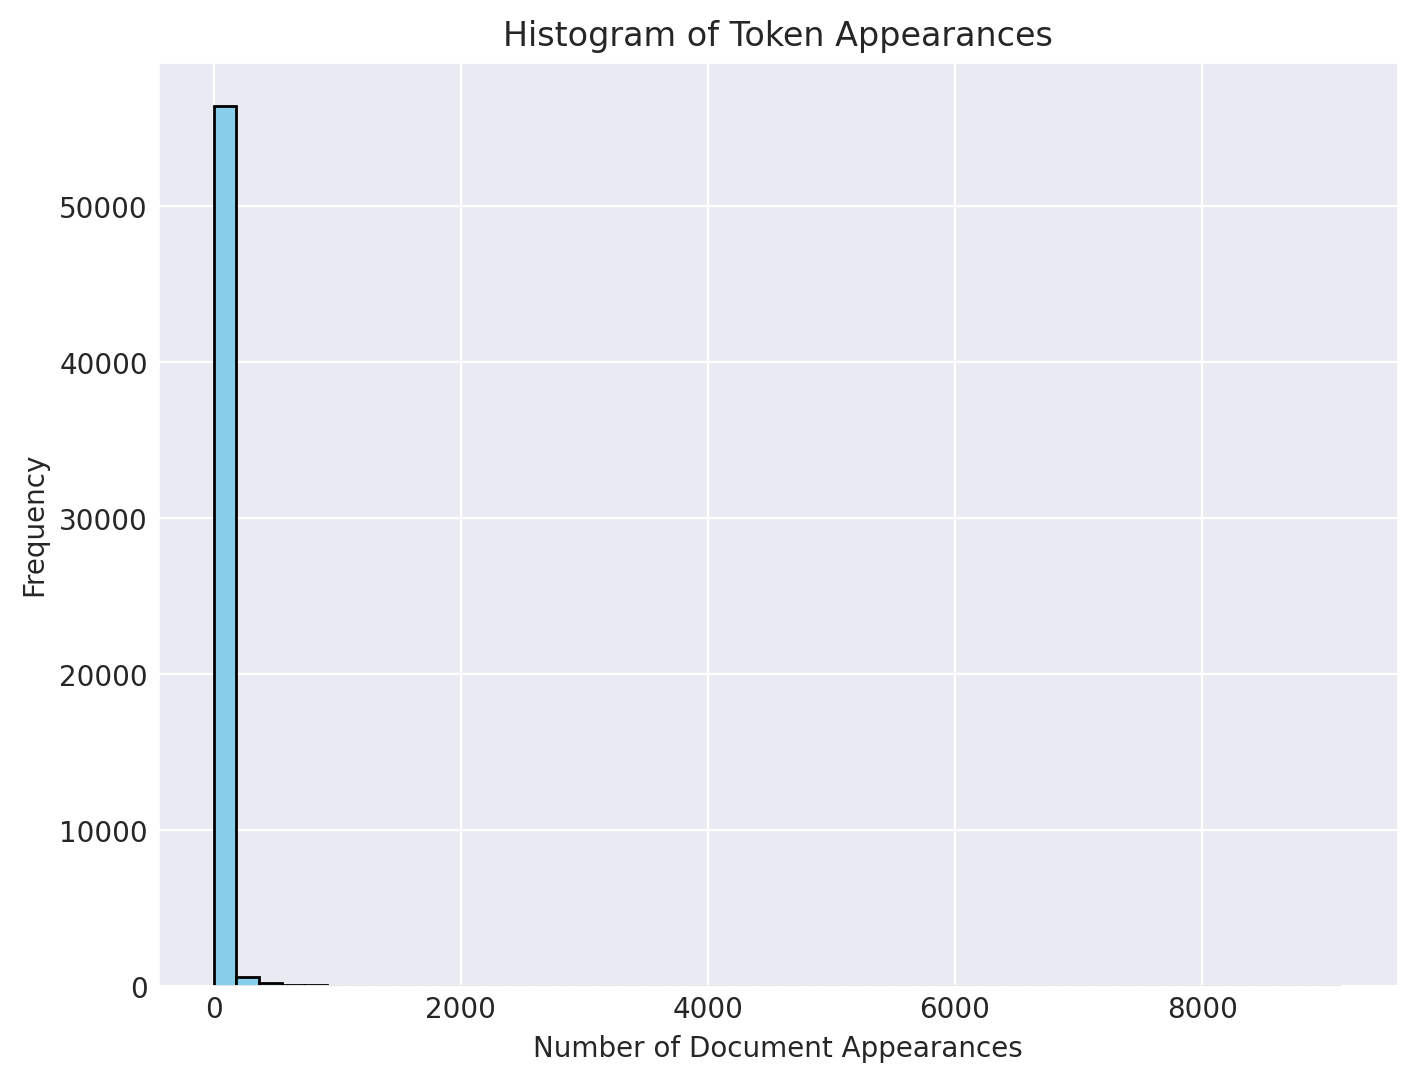

In [ ]:
# Create a DataFrame with 'token' and 'ndocs' columns
df = pd.DataFrame({
    'token': D.values(),
    'ndocs': [D.dfs[token_id] for token_id in D.keys()]
})
# Sort DataFrame by 'ndocs'
df = df.sort_values(by='ndocs', ascending=False)

# Print how many tokens only appear once
tokens_appearing_once = df[df['ndocs'] == 1]
print(len(tokens_appearing_once))

# Remove tokens appearing in exactly one document from the DataFrame
df = df[df['ndocs'] > 1]
print(df.shape)

# Most common token in terms of document occurrence
most_common_token = df.iloc[0]
print(most_common_token)
# Least common token in terms of document occurrence
least_common_token = df.iloc[-1]
print(least_common_token)

# Plot a histogram of token appearances
plt.hist(df['ndocs'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Document Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Token Appearances')
plt.show()

Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

   - terms that appear in most documents are probably not very informative in the general context of a particular corpus
   - terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases, we find that many of the words that are eliminated for this reason can be typos.

In [ ]:
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 33047 terms


You can check dictionary size has been considerably reduced with respect to the original vocabulary.

In [ ]:
corpus_def = []
# Para cada frase del corpus original (sin reducir tokens)
for sent in corpus:
  # Se cogen los token del corpus original que aparecen en el diccionario tras eliminar los tokens según su frecuencia de aparicion
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)
# Ahora tienes un corpus reducido (el diccionario ha sido util para eliminar esos token según su frecuencia)
corpus_df['clean_review'] = corpus_def
print(corpus_df.shape)

(15000, 3)


### *2.3. Bag-Of-Words (BoW)*

Next, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such a token in `token_list`.

In [ ]:
# Recordemos que el diccionario D es del tipo indice:token, el indice no representa el número de ocurrencias
# doc2bow no es lo mismo que D.dfs, D.dfs mide las ocurrencias de cada token en TODOS los documentos de forma conjunta
# mientras que doc2bow lo que hace es generarse un BoW para CADA documento del corpus
# recordemos también que cada doc en el corpus es una review (en este notebook en concreto)
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print(colored('============= Review (lemmas) =============', 'blue'))
print(' '.join(corpus[n_review]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(reviews_bow[n_review])

print(colored('\n============= Word counts for the review =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
film really used locations well amazing shots dark_disturbing film moves_slowly constantly keeps watching modern love worked well gold_coast film fantastic program year offering_audiences glimpse_australian cinema usually_neglected importantly_refreshing see australian_cinema taking cliché_aussie characters story lines seen done death years film would compliment_festival open_debate screenings_performances characters well_developed cinematography fantastic interesting exploration family_relationships environments

============= Sparse vector representation =============
[(14, 1), (77, 2), (92, 2), (109, 4), (155, 1), (159, 1), (173, 1), (211, 1), (213, 1), (233, 1), (290, 1), (498, 1), (531, 1), (682, 1), (1047, 1), (1101, 1), (1277, 1), (1298, 1), (1303, 1), (1451, 2), (1524, 1), (1638, 1), (2186, 1), (2253, 1), (2406, 1), (2702, 1), (4467, 1), (5326, 1), (6095, 1), (6158, 1), (8735, 1), (12229, 1), (14752, 1), (17219, 1), (17220, 1), (17221

Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples

    [(0, 1), (3, 3), (5,2)]

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of the positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

As a summary, we have obtained the following variables that will be relevant for the next sections:

   * `D`: A Gensim dictionary. Term strings can be accessed using numeric identifiers. For instance, `D[0]` contains the string corresponding to the first position in the BoW representation.
   * `mycorpus_bow`: BoW corpus. A list containing an entry per project in the dataset, and consisting of the (sparse) BoW representation for the abstract of that project.

### *2.4. TF-IDF vectorization*

Gensim TFIDF representation of a document is computed as

$$x_{ij} = \text{freq}_{ij} \log_2 \frac{\# docs}{\# docs_j}$$

where:

   - $x_{ij}$ is the component of the TFIDF representation of document $i$ corresponding to term $j$
   - $\text{freq}_{ij}$ is the frequency of term $j$ in a document $i$ (i.e., number of occurrences divided by the number of tokens)
   - $\# docs$ is the total number of documents in the corpus
   - ${\# docs_j}$ is the number of documents in the corpus containing term $j$

In this way, terms that appear in fewer documents get emphasized over common terms appearing in many documents.

Gensim offers the possibility to change the *term frequency* and *inverse document frequency* calculation terms, but we will keep the defaults.

Note that, contrary to the Bag of Words (BoW) representation, the TFIDF representation does not depend just on the tokens of each document, but gets affected by the whole corpus through the IDF factor.

Gensim considers TFIDF as a model on its own and deals with it similarly to what is done with other models. Creating a TFIDF model is very simple

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow)

A **TFIDF model cannot be updated** adding more documents. Otherwise, we would lose consistency, i.e., the TFIDF representation for a particular document would change before and after the TFIDF model gets updated.

From now on, `tfidf` can be used to convert any vector from the old representation (bow integer counts) to the new one (TFIDF real-valued weights), or to apply a transformation to a whole corpus

In [ ]:
reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(reviews_tfidf[n_review])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(14, 0.10406994103290339), (77, 0.09176790405658601), (92, 0.11489539134088768), (109, 0.08547971999209841), (155, 0.043098613136611494), (159, 0.04434811063583127), (173, 0.03552617628844363), (211, 0.10888361772302774), (213, 0.06565644308357191), (233, 0.06261145383029433), (290, 0.08653815759188022), (498, 0.1320394773215498), (531, 0.04308267230085391), (682, 0.14029028579946692), (1047, 0.08050700391110595), (1101, 0.0971676984024217), (1277, 0.1149975497918864), (1298, 0.1176417557430181), (1303, 0.11328054429608134), (1451, 0.2631042898427758), (1524, 0.12329972762904488), (1638, 0.12502829029568266), (2186, 0.09544961599229387), (2253, 0.07217313422229028), (2406, 0.13003625564768018), (2702, 0.14958545994652414), (4467, 0.16662560315915295), (5326, 0.1342671456962113), (6095, 0.25909647875172703), (6158, 0.17971148012361055), (8735, 0.20426864977445208), (12229, 0.26282924450490985), (14752, 0.20910731705516045

As for BOW, TFIDF provides a sparse document representation.

### *2.5. Memory efficient computation*

In the previous examples, the construction of the dictionary and the transformation of the corpus to BoW or TFIDF format required that said corpus of documents be available in a list in the execution environment, and therefore required it to be stored in RAM. For a small corpus, this is not a problem, but it can be an important limitation when dealing with a large corpus with millions or tens of millions of documents. These corpora are becoming more and more common in certain applications (consider Wikipedia entries, user opinions on large e-commerce platforms, processing of medical records, etc.).

One of the advantages of Gensim is that its implementation makes it easy to work with a corpus of these sizes. As explained in the Gensim documentation:

> Note that the corpus above resides fully in memory, as a plain Python list. In this simple example, it doesn’t matter much, but just to make things clear, let’s assume there are millions of documents in the corpus. Storing all of them in RAM won’t do. Instead, let’s assume the documents are stored in a file on disk, one document per line. Gensim only requires that a corpus must be able to return one document vector at a time.

>The full power of Gensim comes from the fact that a corpus doesn’t have to be a list, a NumPy array, a Pandas dataframe, or whatever. Gensim accepts any object that, when iterated over, successively yields documents.

The next fragment of code illustrates how the dictionary can be created from a corpus stored in a text file. You just need to create an iterator that returns a document at each iteration and keeps adding documents to the dictionary. Note that during the execution of the code, only one document is kept in memory at every iteration.

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower()

MyIterCorpus = IterableCorpus_fromfile('imdb_lemmas_clean.txt')
newD = Dictionary()
# Aquí antes de añadirtelo a un diccionario podrias limpiar las palabras, lematizar, homogeneizar, etc...
for doc in MyIterCorpus:
  newD.add_documents([doc.split()])
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

The code above can be further simplified if the iterator already carries out the tokenization of each document. In that case, the dictionary can be created with a simple command:

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('imdb_lemmas_clean.txt')
newD = Dictionary(MyIterCorpus)
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

# Numero de documentos (reviews) que ha procesado el diccionario
print('Number of documents processed:', newD.num_docs)
# Número de palabras del diccionario
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 15000
Number of elements in dictionary: 33047


### *2.7. Compatibility with Numpy and Scipy*


Gensim contains efficient functions to convert Gensim Corpus (BoW, TFIDF) to Numpy dense matrices or Scipy Sparse Matrices. This can be useful, e.g., if we wish to use the vectorial representation of a Gensim corpus to train a classification or regression model using sklearn.

Similarly, we also have functions to convert Numpy or Scipy matrices into Gensim representation.

More information on the available utilities can be found in the [Gensim API matutils documentation](https://radimrehurek.com/gensim/matutils.html).


Sklearn also includes functions for tokenization and vectorization of documents. Specifically, it has the functions:
* [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) which implements both tokenization and word count (BoW) in a single class.
* [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) which is responsible for obtaining the TF-IDF representation from a BoW representation.

* [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) which is equivalent to using `CountVectorizer()` followed by `TfidfTransformer()`.

## **3. Sentiment Analysis with BoW and TF-IDF representations**
---

Let's start by loading the problems labels.

In [ ]:
def get_binary_label(sentiment):
  return 1 if sentiment == "positive" else 0

corpus_df['binary_sentiment'] = corpus_df['sentiment'].apply(get_binary_label)

Y = corpus_df['binary_sentiment'].values
print(Y)

[1 0 0 ... 0 1 1]


And save all the changes we have made in ``corpus_df`` for later use.

In [ ]:
import pickle

def pickler(file: str, ob):
    """Pickle object to file"""
    with open(file, 'wb') as f:
        pickle.dump(ob, f)
    return 0

pickler("corpus_df_imbdb.pickle",corpus_df)

0

Since we have carried out the vectorization with Gensim,  we have to convert our vector representation into NumPy arrays so we can use Sklearn's classifiers. To do this, Gensim includes two functions: [corpus2dense](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2dense.html), [corpus2csc](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2csc.html). In general, when dealing with huge corpora, we will be interested in managing the sparse form of the data to save on computational costs.


In [ ]:
from gensim.matutils import corpus2dense, corpus2csc

n_tokens = len(D)
num_docs = len(reviews_bow)

# Convert BoW representacion
corpus_bow_dense = corpus2dense(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T
corpus_bow_sparse = corpus2csc(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

# La representación sparse del vector simplemente indica el índice de los datos diferentes de cero y su valor
# Por ejemplo [(41,1), (48,2.75)] Indica que, del vector original, sólo hay valroes distintos de 0 en el índice 41 (1) y en el 48 con valor de 2.75

##### **Exercise 9**

Train an SVM classifier with the BoW representation of the IMDB dataset. Use the Sklearn function ``train_test_split`` to split the BOW representation of the reviews with a $70/30$ ratio each and a random state of $42$. Find the best hyperparameters for the SVM (``C`` and ``kernel``) via cross-validation with [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Evaluate the performance of the classifier based on the [R2 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

svm_model = svm.SVC()

param_grid = {'C': [1, 10], 'kernel': ['linear', 'poly', 'sigmoid']}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(corpus_bow_sparse, corpus_df['binary_sentiment'], test_size=0.3, random_state=42)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ['linear', 'poly', 'sigmoid']})

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, grid_search.predict(X_test))
print(r2)

0.5093143359229315


In [ ]:
# Impossible to do it with dense_bow, too much RAM space needed (not optimal at all)
'''from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
svm_model = svm.SVC()

param_grid = {'C': [0.1, 1], 'kernel': ['linear']}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(corpus_bow_dense, corpus_df['binary_sentiment'], test_size=0.3, random_state=42)
grid_search.fit(X_train, y_train)'''

##### **Exercise 10**

Mimic the steps from Exercise 9 to train an SVM classifier with the TF-IDF representation.

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

svm_model = svm.SVC()

param_grid = {'C': [1, 10], 'kernel': ['linear', 'poly', 'sigmoid']}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(corpus_tfidf_sparse, corpus_df['binary_sentiment'], test_size=0.3, random_state=42)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ['linear', 'poly', 'sigmoid']})

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, grid_search.predict(X_test))
print(r2)

0.5830949701953894


---
In this first laboratory, we have covered the necessary preprocessing steps that need to be applied to a text corpus previous to its vectorization using several state-of-the-art Python libraries. We have then seen how to obtain BoW and TFIDF representations based on the Gensim library and how to use them for a Sentiment Analysis problem.

While we will see that Bag-of-Words and TF-IDF as they neither capture the context of words nor allow for similarity comparison, it is still important to know how they work and how to use them, since they still provide quite good results in some tasks, as we have seen in this notebook.

To finish, it is also important that you get confident with the Genism library as you will be using it a lot in this course!
